In [1]:
import pdb

import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os.path

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import pdb
from src.utils.util import approx_probs


sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

PREFIX="user72/bertfornli-exp1"

WANDB_RUN_PATHS = [
  "S9.04_gamma-2.0_adamw-1e-06_bs-1x32_lr-2e-05_wd-0.1_e-10_prec-16_06.13_16.17.03",
  "S7.03_gamma-0.0_adamw-1e-06_lr-2e-05_e-10_precision-32_06.11_11.18.07"
]


WANDB_RUN_PATHS = [os.path.join(PREFIX, run_name) for run_name in WANDB_RUN_PATHS]

def load_all_tables(wandb_run, artifact_filter_str, csv_file_path_in_artifact, cache_path="/tmp/wandb"):
    artifacts = [a for a in wandb_run.logged_artifacts() if artifact_filter_str in a.name]
    df_all = pd.DataFrame({})
    for artifact in tqdm(artifacts):
        artifact_dir = artifact.download(os.path.join(cache_path, f"{artifact.name}"))
        csv_path = os.path.join(artifact_dir, csv_file_path_in_artifact)

        df = pd.read_csv(csv_path)
        df = df.reset_index()
        df["artifact_name"] = artifact.name
        df_all = pd.concat([df_all, df])

    df_all = df_all.reset_index()
    return df_all


# Initialize wandb
wapi = wandb.Api()
print("getting runs")
wruns = [wapi.run(wrp) for wrp in WANDB_RUN_PATHS]

# for wrun in wruns:
    # wandb_logger = wandb.init(entity=wrun.entity, project=wrun.project, id=wrun.id, resume=True)

print("loading dataframes")
# MNLI dataframes
focal_mnli_df = load_all_tables(
    wandb_run=wruns[0],
    artifact_filter_str="Valid-mnli_epoch_end_df",
    csv_file_path_in_artifact='df.csv',
)

ce_mnli_df = load_all_tables(
    wandb_run=wruns[1],
    artifact_filter_str="Valid-mnli_epoch_end_df",
    csv_file_path_in_artifact='df.csv',
)

focal_hans_df = load_all_tables(
    wandb_run=wruns[0],
    artifact_filter_str="Valid-hans_epoch_end_df",
    csv_file_path_in_artifact='df.csv',
)

ce_hans_df = load_all_tables(
    wandb_run=wruns[1],
    artifact_filter_str="Valid-hans_epoch_end_df",
    csv_file_path_in_artifact='df.csv',
)

#valid_mnli_df = load_all_tables(
#    wandb_run=wrun,
#    artifact_filter_str="Valid-mnli_epoch_end_df",
#    csv_file_path_in_artifact='df.csv',
#)
#
## HANS dataframes
#valid_hans_df = load_all_tables(
#    wandb_run=wrun,
#    artifact_filter_str="Valid-hans_epoch_end_df",
#    csv_file_path_in_artifact='df.csv',
#)

getting runs
loading dataframes


100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [3]:
focal_hans_df = focal_hans_df[["epoch", "losses"]].copy()
focal_hans_df = focal_hans_df.rename(columns={"losses":"loss"})
focal_hans_df["loss_type"] = "Focal Loss"
focal_hans_df["type_str"] = "HANS"

ce_hans_df = ce_hans_df[["epoch", "losses"]].copy()
ce_hans_df = ce_hans_df.rename(columns={"losses":"loss"})
ce_hans_df["loss_type"] = "CE Loss"
ce_hans_df["type_str"] = "HANS"


In [4]:
focal_df = focal_mnli_df[["epoch", "loss", "type_str"]].copy()
focal_df["loss_type"] = "Focal Loss"
ce_df = ce_mnli_df[["epoch", "loss", "type_str"]].copy()
ce_df["loss_type"] = "CE Loss"

In [5]:
print(len(focal_df))
print(len(ce_df))

combined = pd.concat([focal_df, ce_df, focal_hans_df, ce_hans_df]).reset_index()

print(len(focal_df) + len(ce_df))
print(len(combined))
print(combined.head())

294450
294450
588900
2388900
   index  epoch      loss  type_str   loss_type
0      0      0  0.028757  Standard  Focal Loss
1      1      0  0.042616  Standard  Focal Loss
2      2      0  0.514962  Standard  Focal Loss
3      3      0  0.192241  Standard  Focal Loss
4      4      0  0.007790  Standard  Focal Loss


In [6]:
def process_dataframe(df, gamma):
    # remove some epochs to be faster
    df = df[df.epoch % 2 == 0]

    # remove outliers because they hurt the plots

    old_size = len(df)

    def get_outlier_mask(column):
        cutoff = np.percentile(column, 90)
        return column > cutoff

    outliers = df.groupby(["type_str", "epoch", "loss_type"])['loss'].apply(get_outlier_mask)

    print(outliers.index)
    print(outliers.astype(int).mean())

    df = df[~outliers]
    new_size = len(df)

    print(f"new size {new_size}")
    print(f"old size {old_size}")
    assert new_size >= int(old_size * 0.8)

    # add a group attribute
    group_dict = {
        "Standard":0,
        "Heuristic_E":1,
        "Heuristic_Ne":1,
        "Noise":2,
        "Trivial":2
    }
    df['group'] = df['type_str'].map(group_dict)

    # estimate probs because we didn't log them when running the experiments
    df['pred'] = 0

    df.loc[df["loss_type"] == "Focal Loss", "pred"] = approx_probs(df[df["loss_type"] == "Focal Loss"]['loss'].to_numpy(), gamma=2, f_start=0.0001, resolution=0.0005)
    df.loc[df["loss_type"] != "Focal Loss", "pred"] = np.exp(-     df[df["loss_type"] != "Focal Loss"]['loss'].to_numpy())

    # sanity check that our estimated probabilites make sense
    preds = df['pred'].to_numpy()
    actual_loss = df['loss'].to_numpy()
    gammas = (df['loss_type'] == "Focal Loss").to_numpy() * 2
    recreated_loss = - ((1 - preds)**gammas) * np.log(preds)
    assert np.abs(actual_loss - recreated_loss).max() < 0.01

    return df

processed_df = process_dataframe(combined, gamma=2)


Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            2298890, 2298891, 2298892, 2298893, 2298894, 2298895, 2298896,
            2298897, 2298898, 2298899],
           dtype='int64', length=1194450)
0.09986939595629787
new size 1075161
old size 1194450


  4%|▎         | 686/18417 [00:00<00:21, 814.51it/s]/home/axel/Documents/MLOpt/optml-proj/src/utils/util.py:78: RuntimeWarning: invalid value encountered in log
  y = -(1 - prob) ** gamma * np.log(prob)
100%|██████████| 18417/18417 [00:30<00:00, 605.23it/s]


before (537671,)
after (537671,)


In [7]:
print(processed_df.head())

   index  epoch      loss  type_str   loss_type  group      pred
0      0      0  0.028757  Standard  Focal Loss    0.0  0.710960
1      1      0  0.042616  Standard  Focal Loss    0.0  0.672630
2      2      0  0.514962  Standard  Focal Loss    0.0  0.324176
3      3      0  0.192241  Standard  Focal Loss    0.0  0.484937
4      4      0  0.007790  Standard  Focal Loss    0.0  0.810863


In [8]:
# PLOT LOSS DISTRIBUTION

import matplotlib as mpl

NEUTRAL_COLOR = "grey"

# df = valid_mnli_df[["step", "loss", "type_str"]].rename(columns={"step": "epoch"})
save_path=f"{wrun.name}__train__loss_ridgeline.png"
show_plot=True
dpi=200
sns.set(font_scale = 2)
sns.set_style("white")

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(df.type_str.unique()), rot=-.25, light=.7)
g = sns.FacetGrid(
    df, row="epoch", hue="type_str", col="group",
    sharex=True, sharey=False,
    aspect=3, height=3,# , palette=pal,
    hue_order=["Standard",
               "Heuristic_E",
               "Heuristic_Ne",
               "Noise",
               "Trivial"])

# Draw the densities in a few steps
bw_adjust = 0.6
g.map(sns.kdeplot, "loss", bw_adjust=bw_adjust,
        clip_on=False, fill=True, alpha=.5, linewidth=0.5,
        log_scale=True)
g.map(sns.kdeplot, "loss", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust, log_scale=True)


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1.5, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label, **kwargs):
    years = x.unique().tolist()  # TODO very hacky
    assert len(years) == 1
    ax = plt.gca()
    ax.text(0, .2, f"Epoch:{years[0]}", fontweight="bold", color=None,
            ha="left", va="center", transform=ax.transAxes, fontsize=16)

g.map(label, "epoch")
g.set_axis_labels(x_var="Loss", y_var="Density", fontsize=16)  # TODO very hacky

mpl.rcParams["legend.title_fontsize"] = 24
g.add_legend(title="Sample types", fontsize = 20)
#plt.figtext(0.0, 0.5, 'Density', fontsize=18, ha='center', rotation="vertical")
plt.figtext(0.5, 1.0, 'Loss distribution across sample type and training epochs', fontsize=30, ha='center')

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set(yticks=[])
#g.set(ylabel="")
g.set_titles("")
g.despine(bottom=True, left=True)

g.savefig(save_path, dpi=dpi, format='png')

g.tight_layout()

if show_plot:
    plt.show()

plt.close()

NameError: name 'wrun' is not defined

In [9]:

# PLOT PROBS DISTRIBUTION

df = processed_df
df

,index,epoch,loss,type_str,loss_type,group,pred
0,0,0,0.028757,Standard,Focal Loss,0.0,0.710960
1,1,0,0.042616,Standard,Focal Loss,0.0,0.672630
2,2,0,0.514962,Standard,Focal Loss,0.0,0.324176
3,3,0,0.192241,Standard,Focal Loss,0.0,0.484937
4,4,0,0.007790,Standard,Focal Loss,0.0,0.810863
...,...,...,...,...,...,...,...
2298895,809995,8,0.000901,HANS,CE Loss,NaN,0.999099
2298896,809996,8,0.000111,HANS,CE Loss,NaN,0.999889
2298897,809997,8,0.000153,HANS,CE Loss,NaN,0.999847
2298898,809998,8,0.000234,HANS,CE Loss,NaN,0.999766


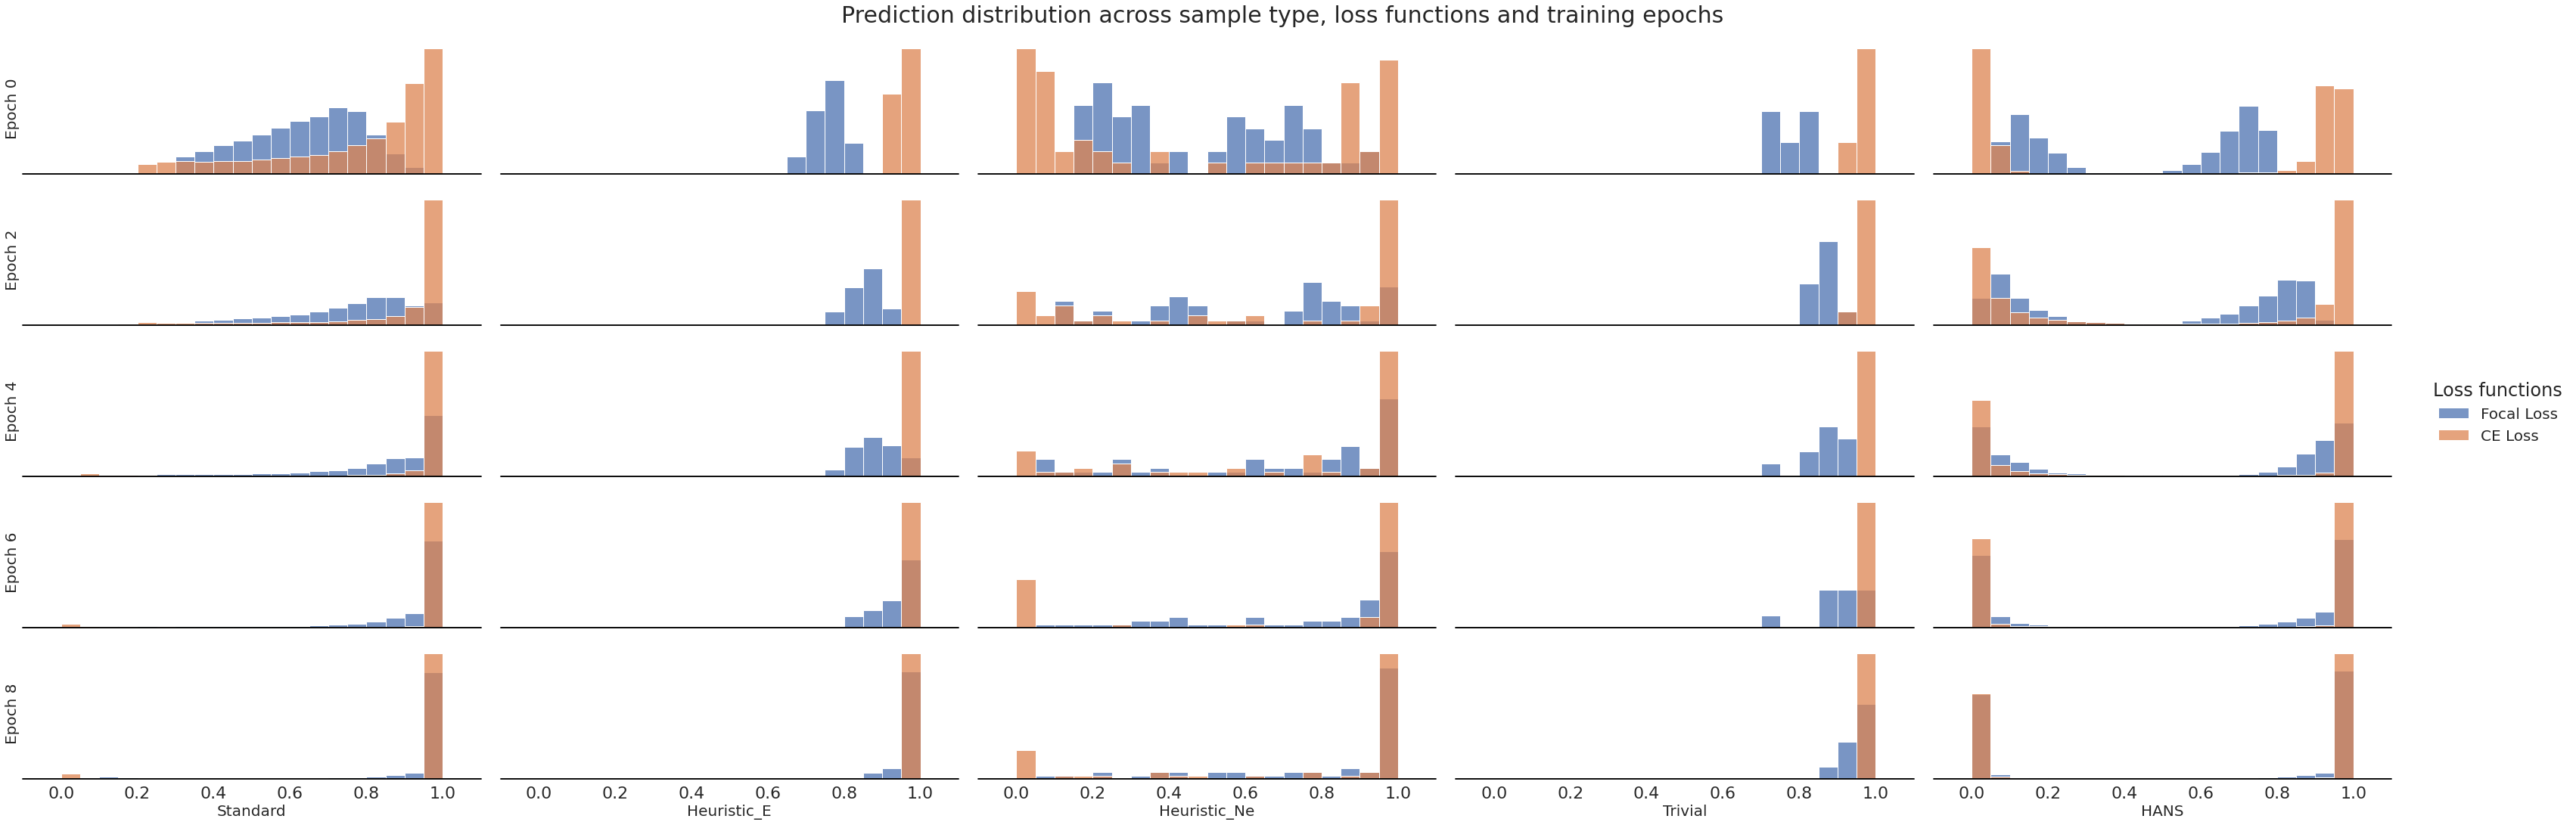

In [10]:
import matplotlib as mpl

NEUTRAL_COLOR = "grey"

save_path=f"train__prob_ridgeline.png"
show_plot=True
dpi=200
sns.set(font_scale = 2)
sns.set_style("white")

col_order = ["Standard", "Heuristic_E", "Heuristic_Ne", "Trivial", "HANS"]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(df.type_str.unique()), rot=-.25, light=.7)
g = sns.FacetGrid(
    df, row="epoch", hue="loss_type", col="type_str",
    sharex=True, sharey=False,
    aspect=3, height=3,# , palette=pal,
    xlim=(-0.1, 1.1),
    col_order=col_order)


# Draw the densities in a few steps
#bw_adjust = 0.6
#g.map(sns.kdeplot, "pred", bw_adjust=bw_adjust,
#        clip_on=False, fill=True, alpha=.5, linewidth=0.5,
#        log_scale=False, clip=(-0.1,1.1))
#g.map(sns.kdeplot, "pred", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust, log_scale=False, clip=(-0.1,1.1))


#g.map_dataframe(sns.histplot, y="preds")
g.map(sns.histplot, "pred", binwidth=0.05, stat="density", binrange=(0,1))

#g.map(sns.histplot, "pred", binwidth=0.05, stat="density", hatch="\\", alpha=0.5,
#      binrange=(0,1))
#g.map(sns.histplot, "focal_pred", binwidth=0.05, stat="density", hatch="/", alpha=0.5,
#      binrange=(0,1))

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1.5, linestyle="-", color="black", clip_on=False)

# Define and use a simple function to label the plot in axes coordinates

for i, name in enumerate(col_order):
    g.axes[4, i].set_xlabel(name, fontsize=20)

for i in range(5):
    g.axes[i, 0].set_ylabel(f"Epoch {i*2}", fontsize=20)
    for j in range(1,5):
        g.axes[i, j].set_ylabel("")

mpl.rcParams["legend.title_fontsize"] = 24
g.add_legend(title="Loss functions", fontsize = 20)
#plt.figtext(0.0, 0.5, 'Density', fontsize=18, ha='center', rotation="vertical")
plt.figtext(0.5, 1.0, 'Prediction distribution across sample type, loss functions and training epochs', fontsize=30, ha='center')

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set(yticks=[])
#g.set(ylabel="")
g.set_titles("")
g.despine(bottom=True, left=True)

g.savefig(save_path, dpi=dpi, format='png')

g.tight_layout()

if show_plot:
    plt.show()

plt.close()